In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import chime
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [12]:
%load_ext chime

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


# Bayesian search on an XGBoost classifier

Kaggle Playground Series - Season 3, Episode 7

https://www.kaggle.com/competitions/playground-series-s3e7/overvie



# Data preparation

In [13]:
train = pd.read_csv('./data/train.csv', index_col='id'); train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,3,0,0,4,0,0,1,160,2018,12,30,1,0,0,0,140.00,2,1
42096,2,0,0,3,0,0,0,34,2017,9,23,0,0,0,0,224.67,0,0
42097,2,0,0,2,2,0,0,292,2018,7,21,0,0,0,0,96.00,0,0


In [14]:
X_train = train.drop(columns='booking_status')
y_train = train.booking_status

In [15]:
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), 
                       columns=X_train.columns, 
                       index=X_train.index)
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
id,,,,,,,,,,,,,,,,,
0,0.151040,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-1.170469,0.409661,-2.330398,-0.214091,0.428551,5.766758,33.699120,-0.101479,-0.998052,-0.737691
1,0.151040,-0.313454,0.130259,-0.278849,-0.407020,-0.160945,-0.515173,0.161740,0.409661,-0.209778,1.473487,-1.149928,-0.173408,-0.060506,-0.101479,-0.870153,-0.737691
2,0.151040,-0.313454,-0.998814,-0.979466,-0.407020,-0.160945,-0.515173,2.604122,0.409661,1.557404,-1.564154,-1.149928,-0.173408,-0.060506,-0.101479,-1.415406,-0.737691
3,-1.753925,-0.313454,-0.998814,-0.278849,1.294624,-0.160945,-0.515173,-0.886758,0.409661,1.557404,-1.676659,0.428551,-0.173408,-0.060506,-0.101479,-1.307702,-0.737691
4,0.151040,-0.313454,0.130259,-1.680084,-0.407020,-0.160945,-0.515173,1.901012,0.409661,0.850531,0.010919,-1.149928,-0.173408,-0.060506,-0.101479,-0.122955,-0.737691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,2.056005,-0.313454,-0.998814,1.122386,-0.407020,-0.160945,0.685890,0.692156,0.409661,1.557404,1.585992,0.428551,-0.173408,-0.060506,-0.101479,0.954088,1.842849
42096,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-0.862087,-2.441040,0.497095,0.798456,-1.149928,-0.173408,-0.060506,-0.101479,3.233919,-0.737691
42097,0.151040,-0.313454,-0.998814,-0.278849,2.996268,-0.160945,-0.515173,2.320411,0.409661,-0.209778,0.573445,-1.149928,-0.173408,-0.060506,-0.101479,-0.230659,-0.737691


### XGBoost

In [16]:
from xgboost import XGBClassifier

params = {
    'n_estimators': [10, 25, 50, 75, 100, 150, 250, 500, 700, 750, 1000],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 1],
    'reg_alpha': [1e-4, 5e-4, 7e-4, 0.001, 0.005, 0.007, 0.01, 0.02],
    'reg_lambda': [0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.5]
}

In [17]:
space = {
    'n_estimators': Integer(1, 10000, prior='log-uniform', base=10),
    'max_depth': Integer(1, 10, prior='uniform'),
    'learning_rate': Real(1e-3, 10, prior='log-uniform', base=10),
    'reg_alpha': Real(1e-4, 20, prior='log-uniform', base=10),
    'reg_lambda': Real(5e-4, 20, prior='log-uniform', base=10)
}

In [18]:
xgboost_clf = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1)

In [19]:
search = BayesSearchCV(estimator=xgboost_clf,
                       search_spaces=space,
                       n_iter=200, 
                       scoring='roc_auc',
                       n_jobs=1,
                       n_points=1, 
                       refit=True,
                       cv=5,
                       verbose=2,
                       random_state=8)

In [20]:
%%time
%%chime
search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0018401978299561485, max_depth=5, n_estimators=2, reg_alpha=0.8752908273535527, reg_lambda=0.0005789554753222284; total time=   0.1s
[CV] END learning_rate=0.0018401978299561485, max_depth=5, n_estimators=2, reg_alpha=0.8752908273535527, reg_lambda=0.0005789554753222284; total time=   0.0s
[CV] END learning_rate=0.0018401978299561485, max_depth=5, n_estimators=2, reg_alpha=0.8752908273535527, reg_lambda=0.0005789554753222284; total time=   0.0s
[CV] END learning_rate=0.0018401978299561485, max_depth=5, n_estimators=2, reg_alpha=0.8752908273535527, reg_lambda=0.0005789554753222284; total time=   0.0s
[CV] END learning_rate=0.0018401978299561485, max_depth=5, n_estimators=2, reg_alpha=0.8752908273535527, reg_lambda=0.0005789554753222284; total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.04775037471896593, max_depth=2, n_estimators=1, reg_alpha=0.0066827

[CV] END learning_rate=0.03046369014395708, max_depth=9, n_estimators=9994, reg_alpha=8.197970878616989, reg_lambda=5.219314646512801; total time=  49.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.17338109101824278, max_depth=10, n_estimators=273, reg_alpha=20.0, reg_lambda=0.044855813036894676; total time=   3.7s
[CV] END learning_rate=0.17338109101824278, max_depth=10, n_estimators=273, reg_alpha=20.0, reg_lambda=0.044855813036894676; total time=   3.9s
[CV] END learning_rate=0.17338109101824278, max_depth=10, n_estimators=273, reg_alpha=20.0, reg_lambda=0.044855813036894676; total time=   3.4s
[CV] END learning_rate=0.17338109101824278, max_depth=10, n_estimators=273, reg_alpha=20.0, reg_lambda=0.044855813036894676; total time=   3.6s
[CV] END learning_rate=0.17338109101824278, max_depth=10, n_estimators=273, reg_alpha=20.0, reg_lambda=0.044855813036894676; total time=   3.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END

[CV] END learning_rate=0.005342327153309056, max_depth=10, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 2.7min
[CV] END learning_rate=0.005342327153309056, max_depth=10, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 2.7min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.06739009531158872, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=20.0; total time=   0.0s
[CV] END learning_rate=0.06739009531158872, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=20.0; total time=   0.0s
[CV] END learning_rate=0.06739009531158872, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=20.0; total time=   0.0s
[CV] END learning_rate=0.06739009531158872, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=20.0; total time=   0.0s
[CV] END learning_rate=0.06739009531158872, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=20.0; total time=   0.0s
Fitting 5 folds for each of 1 candidates,

[CV] END learning_rate=0.18975763455583003, max_depth=10, n_estimators=49, reg_alpha=0.0001, reg_lambda=20.0; total time=   0.9s
[CV] END learning_rate=0.18975763455583003, max_depth=10, n_estimators=49, reg_alpha=0.0001, reg_lambda=20.0; total time=   0.9s
[CV] END learning_rate=0.18975763455583003, max_depth=10, n_estimators=49, reg_alpha=0.0001, reg_lambda=20.0; total time=   0.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.019649201265171518, max_depth=6, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 1.5min
[CV] END learning_rate=0.019649201265171518, max_depth=6, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 1.5min
[CV] END learning_rate=0.019649201265171518, max_depth=6, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 1.5min
[CV] END learning_rate=0.019649201265171518, max_depth=6, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.0005; total time= 1.5min
[CV] END learning_

[CV] END learning_rate=0.001, max_depth=5, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=5, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=5, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=5, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=5, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 1.3min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.04313574619127561, max_depth=4, n_estimators=133, reg_alpha=0.0001, reg_lambda=0.0005; total time=   0.9s
[CV] END learning_rate=0.04313574619127561, max_depth=4, n_estimators=133, reg_alpha=0.0001, reg_lambda=0.0005; total time=   0.9s
[CV] END learning_rate=0.04313574619127561, max_depth=4, n_estimators=133, reg_alpha=0.0001, r

[CV] END learning_rate=0.16906346252299517, max_depth=5, n_estimators=1170, reg_alpha=20.0, reg_lambda=20.0; total time=   4.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.001, max_depth=9, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 2.5min
[CV] END learning_rate=0.001, max_depth=9, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 2.5min
[CV] END learning_rate=0.001, max_depth=9, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 2.5min
[CV] END learning_rate=0.001, max_depth=9, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 2.5min
[CV] END learning_rate=0.001, max_depth=9, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time= 2.5min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.06963711592468892, max_depth=9, n_estimators=1699, reg_alpha=20.0, reg_lambda=20.0; total time=  12.4s
[CV] END learning_rate=0.0696371159246889

[CV] END learning_rate=0.7184685639739852, max_depth=4, n_estimators=10000, reg_alpha=0.0001, reg_lambda=20.0; total time= 1.1min
[CV] END learning_rate=0.7184685639739852, max_depth=4, n_estimators=10000, reg_alpha=0.0001, reg_lambda=20.0; total time= 1.0min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.040394664989858775, max_depth=8, n_estimators=1223, reg_alpha=0.0001, reg_lambda=0.0005; total time=  15.9s
[CV] END learning_rate=0.040394664989858775, max_depth=8, n_estimators=1223, reg_alpha=0.0001, reg_lambda=0.0005; total time=  15.9s
[CV] END learning_rate=0.040394664989858775, max_depth=8, n_estimators=1223, reg_alpha=0.0001, reg_lambda=0.0005; total time=  16.1s
[CV] END learning_rate=0.040394664989858775, max_depth=8, n_estimators=1223, reg_alpha=0.0001, reg_lambda=0.0005; total time=  16.9s
[CV] END learning_rate=0.040394664989858775, max_depth=8, n_estimators=1223, reg_alpha=0.0001, reg_lambda=0.0005; total time=  15.8s
Fitting 5 folds 

[CV] END learning_rate=0.22247428823405024, max_depth=3, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time=  20.8s
[CV] END learning_rate=0.22247428823405024, max_depth=3, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time=  20.7s
[CV] END learning_rate=0.22247428823405024, max_depth=3, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time=  20.8s
[CV] END learning_rate=0.22247428823405024, max_depth=3, n_estimators=10000, reg_alpha=20.0, reg_lambda=0.0005; total time=  20.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.002739365231054363, max_depth=2, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.25809019114503556; total time=  34.7s
[CV] END learning_rate=0.002739365231054363, max_depth=2, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.25809019114503556; total time=  33.3s
[CV] END learning_rate=0.002739365231054363, max_depth=2, n_estimators=10000, reg_alpha=0.0001, reg_lambda=0.25809019114503

[CV] END learning_rate=0.12165529713647782, max_depth=4, n_estimators=2045, reg_alpha=0.0001, reg_lambda=0.0005; total time=  12.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.010532113750520794, max_depth=8, n_estimators=71, reg_alpha=0.0001, reg_lambda=20.0; total time=   1.0s
[CV] END learning_rate=0.010532113750520794, max_depth=8, n_estimators=71, reg_alpha=0.0001, reg_lambda=20.0; total time=   1.1s
[CV] END learning_rate=0.010532113750520794, max_depth=8, n_estimators=71, reg_alpha=0.0001, reg_lambda=20.0; total time=   1.1s
[CV] END learning_rate=0.010532113750520794, max_depth=8, n_estimators=71, reg_alpha=0.0001, reg_lambda=20.0; total time=   1.2s
[CV] END learning_rate=0.010532113750520794, max_depth=8, n_estimators=71, reg_alpha=0.0001, reg_lambda=20.0; total time=   1.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.46565290212189875, max_depth=2, n_estimators=10000, reg_alpha=20.0, reg_lambda=0

[CV] END learning_rate=0.2348072523278025, max_depth=6, n_estimators=46, reg_alpha=20.0, reg_lambda=20.0; total time=   0.5s
[CV] END learning_rate=0.2348072523278025, max_depth=6, n_estimators=46, reg_alpha=20.0, reg_lambda=20.0; total time=   0.5s
[CV] END learning_rate=0.2348072523278025, max_depth=6, n_estimators=46, reg_alpha=20.0, reg_lambda=20.0; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.01187494864821934, max_depth=9, n_estimators=3205, reg_alpha=0.0001, reg_lambda=20.0; total time=  45.4s
[CV] END learning_rate=0.01187494864821934, max_depth=9, n_estimators=3205, reg_alpha=0.0001, reg_lambda=20.0; total time=  45.8s
[CV] END learning_rate=0.01187494864821934, max_depth=9, n_estimators=3205, reg_alpha=0.0001, reg_lambda=20.0; total time=  49.9s
[CV] END learning_rate=0.01187494864821934, max_depth=9, n_estimators=3205, reg_alpha=0.0001, reg_lambda=20.0; total time=  45.2s
[CV] END learning_rate=0.01187494864821934, ma

[CV] END learning_rate=1.20833706925557, max_depth=10, n_estimators=70, reg_alpha=20.0, reg_lambda=20.0; total time=   1.2s
[CV] END learning_rate=1.20833706925557, max_depth=10, n_estimators=70, reg_alpha=20.0, reg_lambda=20.0; total time=   1.2s
[CV] END learning_rate=1.20833706925557, max_depth=10, n_estimators=70, reg_alpha=20.0, reg_lambda=20.0; total time=   1.3s
[CV] END learning_rate=1.20833706925557, max_depth=10, n_estimators=70, reg_alpha=20.0, reg_lambda=20.0; total time=   1.1s
[CV] END learning_rate=1.20833706925557, max_depth=10, n_estimators=70, reg_alpha=20.0, reg_lambda=20.0; total time=   1.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.12602506893729334, max_depth=3, n_estimators=3648, reg_alpha=0.0001, reg_lambda=20.0; total time=  16.9s
[CV] END learning_rate=0.12602506893729334, max_depth=3, n_estimators=3648, reg_alpha=0.0001, reg_lambda=20.0; total time=  16.9s
[CV] END learning_rate=0.12602506893729334, max_depth=3, n_es

[CV] END learning_rate=0.4174359112131632, max_depth=7, n_estimators=23, reg_alpha=0.0001, reg_lambda=0.0005; total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.3923284264075118, max_depth=4, n_estimators=7, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.1s
[CV] END learning_rate=0.3923284264075118, max_depth=4, n_estimators=7, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.1s
[CV] END learning_rate=0.3923284264075118, max_depth=4, n_estimators=7, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.1s
[CV] END learning_rate=0.3923284264075118, max_depth=4, n_estimators=7, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.1s
[CV] END learning_rate=0.3923284264075118, max_depth=4, n_estimators=7, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.014685021460302561, max_depth=4, n_estimators=10000, reg_alpha=0.0001, reg_lambda=20.0; total time

[CV] END learning_rate=0.04622025291292083, max_depth=4, n_estimators=4676, reg_alpha=0.0001, reg_lambda=20.0; total time=  27.8s
[CV] END learning_rate=0.04622025291292083, max_depth=4, n_estimators=4676, reg_alpha=0.0001, reg_lambda=20.0; total time=  28.1s
[CV] END learning_rate=0.04622025291292083, max_depth=4, n_estimators=4676, reg_alpha=0.0001, reg_lambda=20.0; total time=  28.0s
[CV] END learning_rate=0.04622025291292083, max_depth=4, n_estimators=4676, reg_alpha=0.0001, reg_lambda=20.0; total time=  28.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.04519689167888599, max_depth=3, n_estimators=4777, reg_alpha=0.0001, reg_lambda=20.0; total time=  22.1s
[CV] END learning_rate=0.04519689167888599, max_depth=3, n_estimators=4777, reg_alpha=0.0001, reg_lambda=20.0; total time=  22.3s
[CV] END learning_rate=0.04519689167888599, max_depth=3, n_estimators=4777, reg_alpha=0.0001, reg_lambda=20.0; total time=  22.1s
[CV] END learning_rate=0.045196

[CV] END learning_rate=0.2503310282076033, max_depth=10, n_estimators=1, reg_alpha=0.006743695627366958, reg_lambda=0.006432396496594842; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.11803065668300206, max_depth=6, n_estimators=474, reg_alpha=0.0001, reg_lambda=20.0; total time=   4.7s
[CV] END learning_rate=0.11803065668300206, max_depth=6, n_estimators=474, reg_alpha=0.0001, reg_lambda=20.0; total time=   4.5s
[CV] END learning_rate=0.11803065668300206, max_depth=6, n_estimators=474, reg_alpha=0.0001, reg_lambda=20.0; total time=   4.4s
[CV] END learning_rate=0.11803065668300206, max_depth=6, n_estimators=474, reg_alpha=0.0001, reg_lambda=20.0; total time=   4.4s
[CV] END learning_rate=0.11803065668300206, max_depth=6, n_estimators=474, reg_alpha=0.0001, reg_lambda=20.0; total time=   4.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.004456747844578129, max_depth=7, n_estimators=10000, re

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.11305691004110621, max_depth=3, n_estimators=2549, reg_alpha=0.0001, reg_lambda=20.0; total time=  11.8s
[CV] END learning_rate=0.11305691004110621, max_depth=3, n_estimators=2549, reg_alpha=0.0001, reg_lambda=20.0; total time=  11.8s
[CV] END learning_rate=0.11305691004110621, max_depth=3, n_estimators=2549, reg_alpha=0.0001, reg_lambda=20.0; total time=  11.7s
[CV] END learning_rate=0.11305691004110621, max_depth=3, n_estimators=2549, reg_alpha=0.0001, reg_lambda=20.0; total time=  11.8s
[CV] END learning_rate=0.11305691004110621, max_depth=3, n_estimators=2549, reg_alpha=0.0001, reg_lambda=20.0; total time=  11.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.003091269607047954, max_depth=10, n_estimators=10000, reg_alpha=20.0, reg_lambda=20.0; total time= 2.7min
[CV] END learning_rate=0.003091269607047954, max_depth=10, n_estimators=10000, reg_alpha=20.0, reg_la

[CV] END learning_rate=0.38430089259120576, max_depth=6, n_estimators=46, reg_alpha=0.07064844669088606, reg_lambda=0.0005; total time=   0.5s
[CV] END learning_rate=0.38430089259120576, max_depth=6, n_estimators=46, reg_alpha=0.07064844669088606, reg_lambda=0.0005; total time=   0.5s
[CV] END learning_rate=0.38430089259120576, max_depth=6, n_estimators=46, reg_alpha=0.07064844669088606, reg_lambda=0.0005; total time=   0.5s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0039024967956519255, max_depth=8, n_estimators=10000, reg_alpha=0.047501678521344154, reg_lambda=20.0; total time= 2.1min
[CV] END learning_rate=0.0039024967956519255, max_depth=8, n_estimators=10000, reg_alpha=0.047501678521344154, reg_lambda=20.0; total time= 2.1min
[CV] END learning_rate=0.0039024967956519255, max_depth=8, n_estimators=10000, reg_alpha=0.047501678521344154, reg_lambda=20.0; total time= 2.1min
[CV] END learning_rate=0.0039024967956519255, max_depth=8, n_estimators

[CV] END learning_rate=0.012029402041042905, max_depth=5, n_estimators=10000, reg_alpha=0.02335261407871724, reg_lambda=20.0; total time= 1.2min
[CV] END learning_rate=0.012029402041042905, max_depth=5, n_estimators=10000, reg_alpha=0.02335261407871724, reg_lambda=20.0; total time= 1.2min
[CV] END learning_rate=0.012029402041042905, max_depth=5, n_estimators=10000, reg_alpha=0.02335261407871724, reg_lambda=20.0; total time= 1.2min
[CV] END learning_rate=0.012029402041042905, max_depth=5, n_estimators=10000, reg_alpha=0.02335261407871724, reg_lambda=20.0; total time= 1.2min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=10.0, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.0s
[CV] END learning_rate=10.0, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.0s
[CV] END learning_rate=10.0, max_depth=10, n_estimators=1, reg_alpha=20.0, reg_lambda=0.0005; total time=   0.0s
[CV] END learning_rate

[CV] END learning_rate=0.41407680255355167, max_depth=10, n_estimators=10000, reg_alpha=20.0, reg_lambda=20.0; total time=  22.5s
[CV] END learning_rate=0.41407680255355167, max_depth=10, n_estimators=10000, reg_alpha=20.0, reg_lambda=20.0; total time=  21.8s
[CV] END learning_rate=0.41407680255355167, max_depth=10, n_estimators=10000, reg_alpha=20.0, reg_lambda=20.0; total time=  21.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.0013060002662700417, max_depth=7, n_estimators=10000, reg_alpha=0.0518096327279438, reg_lambda=0.0005; total time= 1.9min
[CV] END learning_rate=0.0013060002662700417, max_depth=7, n_estimators=10000, reg_alpha=0.0518096327279438, reg_lambda=0.0005; total time= 1.9min
[CV] END learning_rate=0.0013060002662700417, max_depth=7, n_estimators=10000, reg_alpha=0.0518096327279438, reg_lambda=0.0005; total time= 1.9min
[CV] END learning_rate=0.0013060002662700417, max_depth=7, n_estimators=10000, reg_alpha=0.0518096327279438, r

In [21]:
search.best_params_

OrderedDict([('learning_rate', 0.13640208452847505),
             ('max_depth', 3),
             ('n_estimators', 2721),
             ('reg_alpha', 0.0001),
             ('reg_lambda', 20.0)])

In [22]:
search.best_score_

0.8992162077303021

In [23]:
results = pd.DataFrame(search.cv_results_)

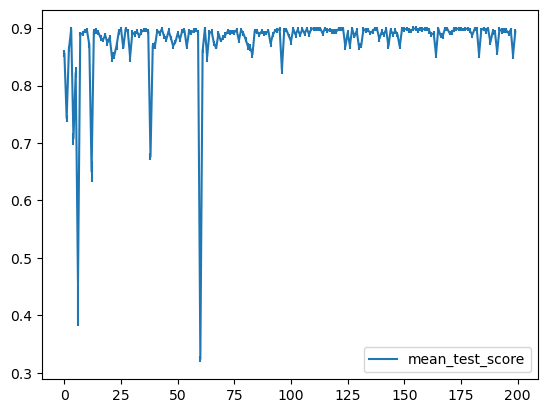

In [24]:
results.plot.line(y='mean_test_score', yerr='std_test_score');

In [25]:
search.best_index_

154

N estimators and lambda are larger than I expected, though it could be over fitting.
Another round:

In [32]:
space_2 = {
    'n_estimators': Integer(2000, 4000, prior='log-uniform', base=10),
    'max_depth': Integer(2, 4, prior='uniform'),
    'learning_rate': Real(0.05, 0.2, prior='log-uniform', base=10),
    'reg_lambda': Real(5, 100, prior='log-uniform', base=10)
}

In [33]:
xgboost_clf_2 = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1,
                           reg_alpha=0.0001)

In [35]:
search_2 = BayesSearchCV(estimator=xgboost_clf_2,
                       search_spaces=space_2,
                       n_iter=50, 
                       scoring='roc_auc',
                       n_jobs=1,
                       n_points=1, 
                       refit=True,
                       cv=5,
                       verbose=1,
                       random_state=8)

In [36]:
%%time
%%chime
search_2.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [37]:
search_2.best_params_

OrderedDict([('learning_rate', 0.19115369742768948),
             ('max_depth', 3),
             ('n_estimators', 3950),
             ('reg_lambda', 96.48423464920053)])

In [38]:
search_2.best_score_

0.8993944218192285

In [39]:
results_2 = pd.DataFrame(search_2.cv_results_)

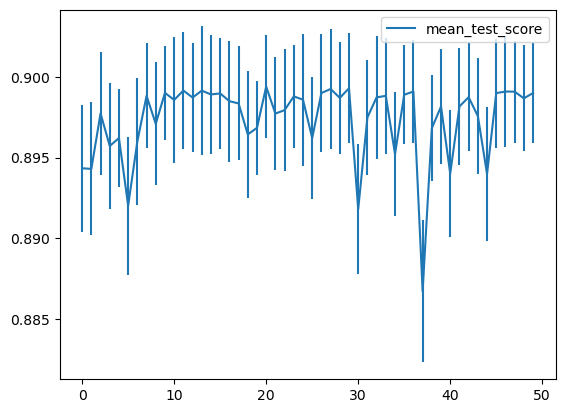

In [40]:
results_2.plot.line(y='mean_test_score', yerr='std_test_score');

In [41]:
search_2.best_index_

20

Marginal improvement, but lambda can be increased even further.

In [43]:
space_3 = {
    'n_estimators': Integer(2000, 5000, prior='log-uniform', base=10),
    'max_depth': Integer(2, 4, prior='uniform'),
    'learning_rate': Real(0.05, 0.2, prior='log-uniform', base=10),
    'reg_lambda': Real(50, 1000, prior='log-uniform', base=10)
}

In [44]:
xgboost_clf_3 = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1,
                           reg_alpha=0.0001)

In [45]:
search_3 = BayesSearchCV(estimator=xgboost_clf_3,
                       search_spaces=space_3,
                       n_iter=50, 
                       scoring='roc_auc',
                       n_jobs=1,
                       n_points=1, 
                       refit=True,
                       cv=5,
                       verbose=1,
                       random_state=8)

In [46]:
%%time
%%chime
search_3.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [47]:
search_3.best_params_

OrderedDict([('learning_rate', 0.12613697225614465),
             ('max_depth', 3),
             ('n_estimators', 4894),
             ('reg_lambda', 79.49916855475958)])

In [48]:
search_3.best_score_

0.8992639785535159

In [49]:
results_3 = pd.DataFrame(search_2.cv_results_)

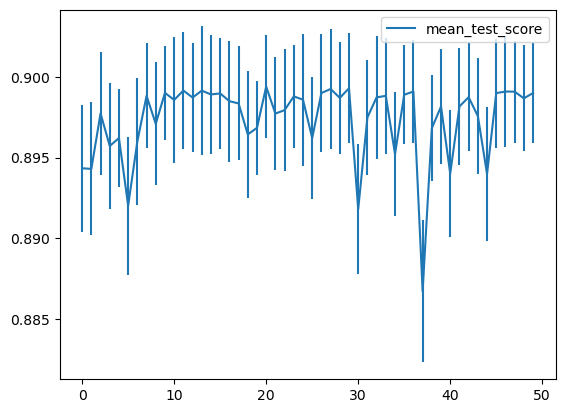

In [50]:
results_3.plot.line(y='mean_test_score', yerr='std_test_score');

In [51]:
search_3.best_index_

48

# Prediction

In [26]:
test = pd.read_csv('./data/test.csv', index_col='id'); test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
id,,,,,,,,,,,,,,,,,
42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70163,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0
70164,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1
70165,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0


In [27]:
X_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)
X_test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
id,,,,,,,,,,,,,,,,,
42100,2.056005,-0.313454,0.130259,1.122386,-0.407020,-0.160945,0.685890,0.087728,0.409661,1.557404,-1.226638,0.428551,-0.173408,-0.060506,-0.101479,0.297092,1.842849
42101,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-1.010111,-2.441040,0.850531,0.573445,-1.149928,-0.173408,-0.060506,-0.101479,-0.526846,-0.737691
42102,0.151040,4.129777,-0.998814,-0.979466,-0.407020,-0.160945,3.088017,-1.059452,0.409661,0.143658,-0.664112,0.428551,-0.173408,-0.060506,-0.101479,3.646696,0.552579
42103,0.151040,-0.313454,-0.998814,0.421768,-0.407020,-0.160945,-0.515173,-0.195983,0.409661,-0.916652,1.585992,-1.149928,-0.173408,-0.060506,-0.101479,-0.641282,-0.737691
42104,-1.753925,-0.313454,-0.998814,-0.278849,2.996268,-0.160945,-0.515173,-1.195140,0.409661,0.497095,0.573445,0.428551,-0.173408,-0.060506,-0.101479,1.061793,-0.737691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70163,0.151040,-0.313454,0.130259,-0.278849,-0.407020,-0.160945,-0.515173,2.604122,0.409661,0.497095,1.585992,0.428551,-0.173408,-0.060506,-0.101479,1.492610,-0.737691
70164,0.151040,-0.313454,1.259332,-0.278849,-0.407020,-0.160945,-0.515173,-0.282330,0.409661,-1.623525,1.023466,-1.149928,-0.173408,-0.060506,-0.101479,-1.065367,0.552579
70165,0.151040,-0.313454,0.130259,-0.278849,-0.407020,-0.160945,-0.515173,-0.788076,0.409661,0.850531,0.685950,-1.149928,-0.173408,-0.060506,-0.101479,-0.526846,-0.737691


In [28]:
y_pred = search.predict_proba(X_test)
y_pred

array([[0.8794274 , 0.12057264],
       [0.93384933, 0.06615064],
       [0.6442263 , 0.35577366],
       ...,
       [0.9308622 , 0.06913778],
       [0.41879284, 0.58120716],
       [0.09027481, 0.9097252 ]], dtype=float32)

In [29]:
result = pd.DataFrame({'id': X_test.index, 'booking_status':y_pred[:, 1]})
result

,id,booking_status
0,42100,0.120573
1,42101,0.066151
2,42102,0.355774
3,42103,0.047295
4,42104,0.325677
...,...,...
28063,70163,0.911546
28064,70164,0.037858
28065,70165,0.069138
28066,70166,0.581207


In [30]:
result.to_csv('bayes_search_xgboost.csv', index=False)

In [52]:
y_pred_2 = search_2.predict_proba(X_test)
y_pred_2

array([[0.89191437, 0.10808564],
       [0.94127655, 0.05872346],
       [0.54789585, 0.45210415],
       ...,
       [0.93234897, 0.06765104],
       [0.49088573, 0.50911427],
       [0.08618528, 0.9138147 ]], dtype=float32)

In [53]:
result_2 = pd.DataFrame({'id': X_test.index, 'booking_status':y_pred_2[:, 1]})
result_2

,id,booking_status
0,42100,0.108086
1,42101,0.058723
2,42102,0.452104
3,42103,0.042141
4,42104,0.401423
...,...,...
28063,70163,0.914897
28064,70164,0.030142
28065,70165,0.067651
28066,70166,0.509114


In [54]:
result_2.to_csv('bayes_search_xgboost_2.csv', index=False)

In [55]:
y_pred_3 = search_3.predict_proba(X_test)
y_pred_3

array([[0.87308025, 0.12691975],
       [0.94111997, 0.05888005],
       [0.56395143, 0.43604857],
       ...,
       [0.93267506, 0.06732492],
       [0.48821574, 0.51178426],
       [0.08909529, 0.9109047 ]], dtype=float32)

In [56]:
result_3 = pd.DataFrame({'id': X_test.index, 'booking_status':y_pred_3[:, 1]})
result_3

,id,booking_status
0,42100,0.126920
1,42101,0.058880
2,42102,0.436049
3,42103,0.043721
4,42104,0.387253
...,...,...
28063,70163,0.921964
28064,70164,0.037139
28065,70165,0.067325
28066,70166,0.511784


In [57]:
result_3.to_csv('bayes_search_xgboost_3.csv', index=False)

# Conclusion
The min_resources parameter was too small so the best manually seleted HP was left out at the first iteration. The resulting score was a bit lower both on crocc-validation and the public test set at the platform.
Need to retry with a larger min. samples.